In [11]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
import datetime
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Bidirectional
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_29 (GRU)                (1, 1, 252)               192780    
                                                                 
 dropout_28 (Dropout)        (1, 1, 252)               0         
                                                                 
 lstm_29 (LSTM)              (1, 128)                  195072    
                                                                 
 dense_44 (Dense)            (1, 12)                   1548      
                                                                 
Total params: 389400 (1.49 MB)
Trainable params: 389400 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 19ms/step
Month=1, Predicted=45.700000, Expected=88.100000
1/1 [==============================] - 0s 20ms/s

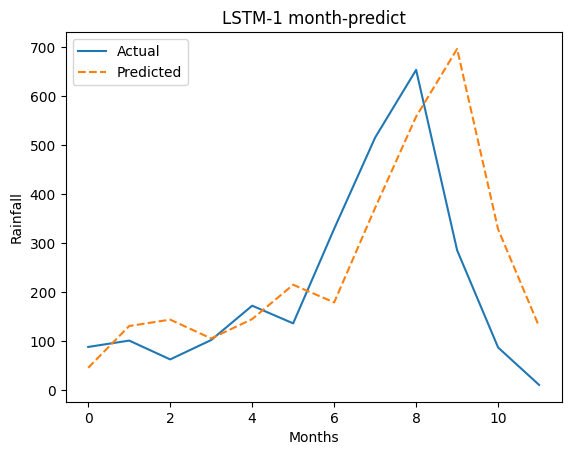

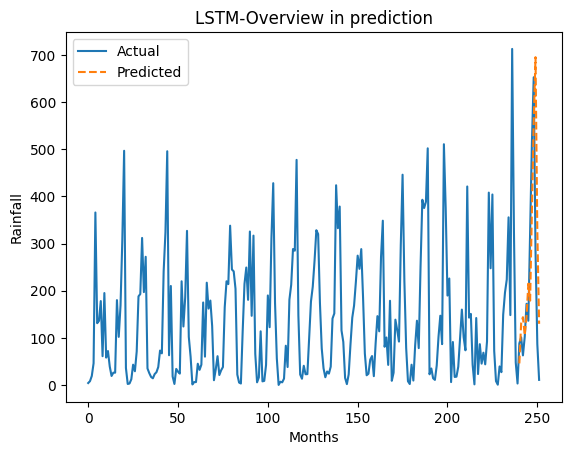

In [39]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(GRU(units=252, return_sequences=True))
	model.add(Dropout(0.1))
	model.add(LSTM(128,dropout=0.1))
	model.add(Dense(12,activation='relu'))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	model.summary()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Nam Định']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
mse = mean_squared_error(raw_values[-12:], predictions)
r2 = r2_score(raw_values[-12:], predictions)
mae = mean_absolute_error(raw_values[-12:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test R2: %.3f' % r2)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.title('LSTM-1 month-predict')
pyplot.plot(raw_values[-12:],label='Actual')
pyplot.plot(predictions,label='Predicted', linestyle='dashed')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

num_data_points_actual = len(raw_values)
num_data_points_predicted = len(predictions)
x_values_actual = numpy.arange(num_data_points_actual)
x_values_predicted = numpy.arange(num_data_points_actual - num_data_points_predicted, num_data_points_actual)

pyplot.plot(x_values_actual,raw_values, label='Actual')
pyplot.plot(x_values_predicted,predictions, label='Predicted', linestyle='dashed')
pyplot.title('LSTM-Overview in prediction')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (1, 1, 60)                11340     
                                                                 
 lstm_23 (LSTM)              (1, 1)                    248       
                                                                 
 dense_39 (Dense)            (1, 1)                    2         
                                                                 
Total params: 11590 (45.27 KB)
Trainable params: 11590 (45.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 33ms/step
Month=1, Predicted=42.391764, Expected=88.100000
1/1 [==============================] - 0s 37ms/step
Month=2, Predicted=62.226227, Expected=101.100000
1/1 [==============================] - 0s 28ms/step
Month=3, Predicted=137.737

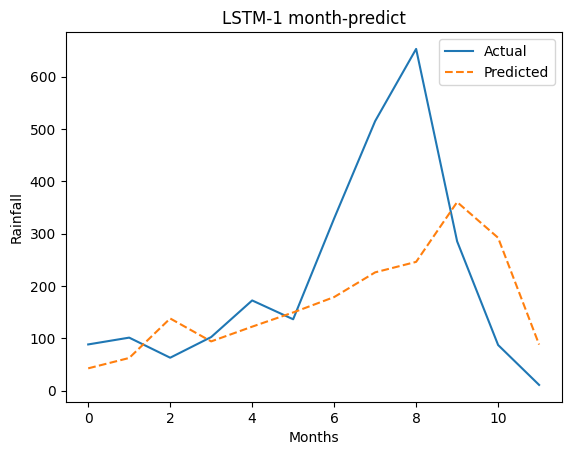

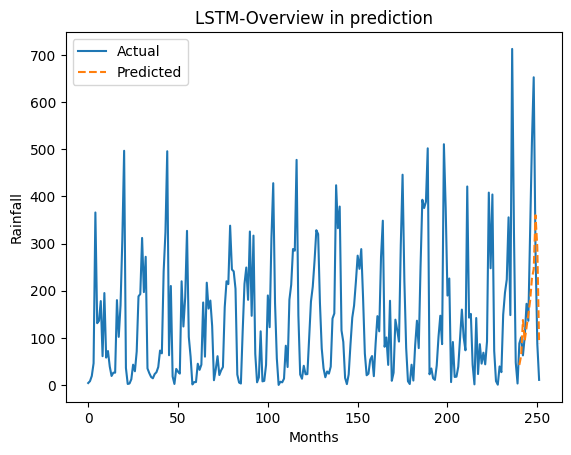

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(GRU(units=12,return_sequences=True))
	model.add(Dropout(0.1))
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,dropout=0.1))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	model.summary()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Nam Định']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
mse = mean_squared_error(raw_values[-12:], predictions)
r2 = r2_score(raw_values[-12:], predictions)
mae = mean_absolute_error(raw_values[-12:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test R2: %.3f' % r2)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.title('LSTM-1 month-predict')
pyplot.plot(raw_values[-12:],label='Actual')
pyplot.plot(predictions,label='Predicted', linestyle='dashed')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

num_data_points_actual = len(raw_values)
num_data_points_predicted = len(predictions)
x_values_actual = numpy.arange(num_data_points_actual)
x_values_predicted = numpy.arange(num_data_points_actual - num_data_points_predicted, num_data_points_actual)

pyplot.plot(x_values_actual,raw_values, label='Actual')
pyplot.plot(x_values_predicted,predictions, label='Predicted', linestyle='dashed')
pyplot.title('LSTM-Overview in prediction')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (1, 1, 60)                11340     
                                                                 
 dropout_18 (Dropout)        (1, 1, 60)                0         
                                                                 
 lstm_17 (LSTM)              (1, 1)                    248       
                                                                 
 dense_32 (Dense)            (1, 1)                    2         
                                                                 
 dense_33 (Dense)            (1, 200)                  400       
                                                                 
Total params: 11990 (46.84 KB)
Trainable params: 11990 (46.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [============

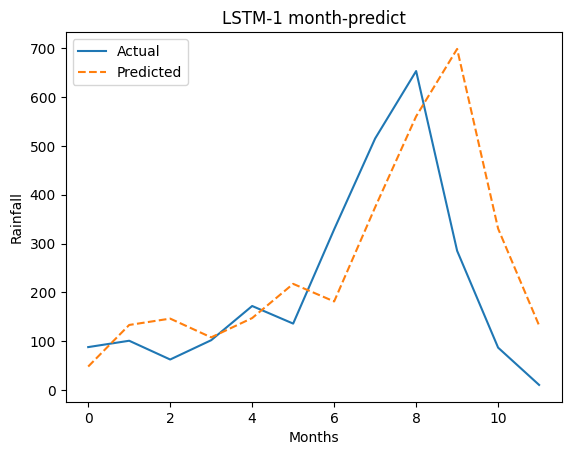

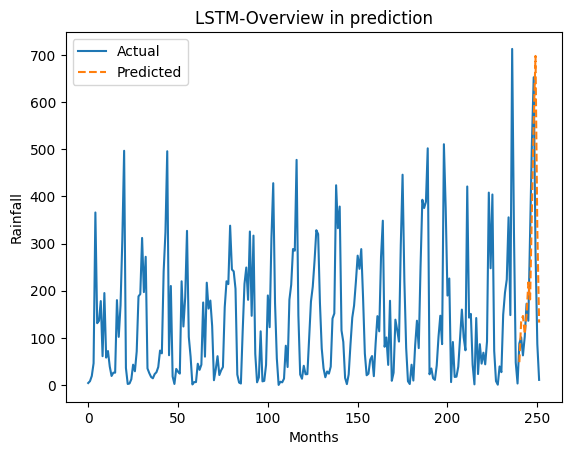

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(GRU(units=12,return_sequences=True))
	model.add(Dropout(0.1)),
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,dropout=0.1))
	model.add(Dense(12))
	model.add(Dense(252, activation='softmax'))
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	model.summary()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Nam Định']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
mse = mean_squared_error(raw_values[-12:], predictions)
r2 = r2_score(raw_values[-12:], predictions)
mae = mean_absolute_error(raw_values[-12:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test R2: %.3f' % r2)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.title('LSTM-1 month-predict')
pyplot.plot(raw_values[-12:],label='Actual')
pyplot.plot(predictions,label='Predicted', linestyle='dashed')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

num_data_points_actual = len(raw_values)
num_data_points_predicted = len(predictions)
x_values_actual = numpy.arange(num_data_points_actual)
x_values_predicted = numpy.arange(num_data_points_actual - num_data_points_predicted, num_data_points_actual)

pyplot.plot(x_values_actual,raw_values, label='Actual')
pyplot.plot(x_values_predicted,predictions, label='Predicted', linestyle='dashed')
pyplot.title('LSTM-Overview in prediction')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

In [41]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(GRU(units=252,return_sequences=True))
	model.add(Dropout(0.05))
	model.add(Bidirectional(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,dropout=0.05,return_sequences=True)))
	model.add(Dense(12, activation='relu'))
	model.add(Dense(12, activation='softmax'))
	model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	model.summary()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Nam Định']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
mse = mean_squared_error(raw_values[-12:], predictions)
r2 = r2_score(raw_values[-12:], predictions)
mae = mean_absolute_error(raw_values[-12:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test RMSE: %.3f' % mse)
print('Test RMSE: %.3f' % r2)
print('Test RMSE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.title('Bi-LSTM-1 month-predict')
pyplot.plot(raw_values[-12:],label='Actual')
pyplot.plot(predictions,label='Predicted', linestyle='dashed')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.legend()
pyplot.show()

num_data_points_actual = len(raw_values)
num_data_points_predicted = len(predictions)
x_values_actual = numpy.arange(num_data_points_actual)
x_values_predicted = numpy.arange(num_data_points_actual - num_data_points_predicted, num_data_points_actual)

pyplot.plot(x_values_actual,raw_values, label='Actual')
pyplot.plot(x_values_predicted,predictions, label='Predicted', linestyle='dashed')
pyplot.title('Bi-LSTM-Overview in prediction')
pyplot.ylabel('Rainfall')
pyplot.xlabel('Months')
pyplot.plot(raw_values)
pyplot.plot(predictions)
pyplot.legend()
pyplot.show()